## Respiratory Illness Classification

In [50]:
#Import necessary packages
import pandas as pd
import numpy as np
import math
import librosa as lb 
import soundfile as sf 
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from sklearn import preprocessing
import wave
import splitfolders
import h5py
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Dense, Flatten, Dropout, SeparableConv1D

Using TensorFlow backend.


In [2]:
#load patient diagnosis.csv
pat_diag = pd.read_csv("patient_diagnosis.csv", names=['pId', 'diagnosis'])

In [3]:
#Preview dataframe
pat_diag

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [4]:
#Diagnosis dataframe information
pat_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pId        126 non-null    int64 
 1   diagnosis  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [5]:
#Check the unique diagnosis label
pat_diag.diagnosis.unique()

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [6]:
#get all unique text files containing audio information
files = [s.split('.')[0] for s in os.listdir(path = "audio_and_txt_files/") if '.txt' in s]

In [7]:
len(files)

920

In [8]:
files[0:10]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200',
 '104_1b1_Ar_sc_Litt3200',
 '104_1b1_Ll_sc_Litt3200',
 '104_1b1_Lr_sc_Litt3200',
 '104_1b1_Pl_sc_Litt3200',
 '104_1b1_Pr_sc_Litt3200']

In [9]:
#Check the audio file's properties such as number of channels, sample width in bytes, framerate, etc.,
audiodata = []
for fn in files:
    file_name = 'audio_and_txt_files/' + fn +'.wav'
    with wave.open(file_name) as f:
        audiodata.append(f.getparams())

In [73]:
audiodata[0:10]

[_wave_params(nchannels=1, sampwidth=3, framerate=44100, nframes=882000, comptype='NONE', compname='not compressed'),
 _wave_params(nchannels=1, sampwidth=3, framerate=44100, nframes=882000, comptype='NONE', compname='not compressed'),
 _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=882000, comptype='NONE', compname='not compressed'),
 _wave_params(nchannels=1, sampwidth=3, framerate=44100, nframes=882000, comptype='NONE', compname='not compressed'),
 _wave_params(nchannels=1, sampwidth=2, framerate=4000, nframes=63424, comptype='NONE', compname='not compressed'),
 _wave_params(nchannels=1, sampwidth=2, framerate=4000, nframes=102336, comptype='NONE', compname='not compressed'),
 _wave_params(nchannels=1, sampwidth=2, framerate=4000, nframes=73920, comptype='NONE', compname='not compressed'),
 _wave_params(nchannels=1, sampwidth=2, framerate=4000, nframes=60096, comptype='NONE', compname='not compressed'),
 _wave_params(nchannels=1, sampwidth=2, framerate=4000, nframes

In [11]:
#wav file properties can also be checked using Soundfile package
ab = sf.SoundFile('audio_and_txt_files/104_1b1_Al_sc_Litt3200.wav')

In [12]:
#File name format as given in the dataset
fname_format = open('filename_format.txt','r')

In [13]:
print(fname_format.read())

Elements contained in the filenames:

Patient number (101,102,...,226)
Recording index
Chest location (Trachea (Tc), {Anterior (A), Posterior (P), Lateral (L)}{left (l), right (r)})
Acquisition mode (sequential/single channel (sc), simultaneous/multichannel (mc))
Recording equipment (AKG C417L Microphone, 3M Littmann Classic II SE Stethoscope, 3M Litmmann 3200 Electronic Stethoscope, WelchAllyn Meditron Master Elite Electronic Stethoscope)


In [14]:
fname_format.close()

In [15]:
#Create a new Dataframe for string the file info
file_data = pd.DataFrame(columns=['fname', 'pId', 'chloc','start', 'end', 'crackles', 'wheezes'])

In [16]:
#read each file and append data to existing data frame
for f in files:
    df = pd.read_csv("audio_and_txt_files/" + f + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    df['fname'] = f
    #get filename features
    f_features = f.split('_')
    df['pId'] = f_features[0]
    df['chloc'] = f_features[2]
    file_data = file_data.append(df, ignore_index=True)


In [17]:
file_data.tail()

,fname,pId,chloc,start,end,crackles,wheezes
6893,226_1b1_Pl_sc_LittC2SE,226,Pl,11.721,13.693,1,0
6894,226_1b1_Pl_sc_LittC2SE,226,Pl,13.693,15.536,0,0
6895,226_1b1_Pl_sc_LittC2SE,226,Pl,15.536,17.493,0,0
6896,226_1b1_Pl_sc_LittC2SE,226,Pl,17.493,19.436,1,0
6897,226_1b1_Pl_sc_LittC2SE,226,Pl,19.436,19.979,0,0


In [18]:
file_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fname     6898 non-null   object 
 1   pId       6898 non-null   object 
 2   chloc     6898 non-null   object 
 3   start     6898 non-null   float64
 4   end       6898 non-null   float64
 5   crackles  6898 non-null   object 
 6   wheezes   6898 non-null   object 
dtypes: float64(2), object(5)
memory usage: 377.4+ KB


In [19]:
file_data['pId'] = file_data['pId'].astype('int64')

In [20]:
file_data = pd.merge(file_data, pat_diag, on='pId')
file_data.head()

,fname,pId,chloc,start,end,crackles,wheezes,diagnosis
0,101_1b1_Al_sc_Meditron,101,Al,0.036,0.579,0,0,URTI
1,101_1b1_Al_sc_Meditron,101,Al,0.579,2.450,0,0,URTI
2,101_1b1_Al_sc_Meditron,101,Al,2.450,3.893,0,0,URTI
3,101_1b1_Al_sc_Meditron,101,Al,3.893,5.793,0,0,URTI
4,101_1b1_Al_sc_Meditron,101,Al,5.793,7.521,0,0,URTI


In [21]:
demog = pd.read_csv('demographic_info.txt', names = 
                 ['pId', 'Age', 'Sex' , 'adult_BMI', 'child_weight' , 'child_height'],
                 sep = ' ')

In [22]:
demog

,pId,Age,Sex,adult_BMI,child_weight,child_height
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0
...,...,...,...,...,...,...
121,222,60.00,M,NaN,NaN,NaN
122,223,NaN,NaN,NaN,NaN,NaN
123,224,10.00,F,NaN,32.3,143.0
124,225,0.83,M,NaN,7.8,74.0


In [23]:
file_data = pd.merge(file_data,demog, on='pId')

In [24]:
file_data

,fname,pId,chloc,start,end,crackles,wheezes,diagnosis,Age,Sex,adult_BMI,child_weight,child_height
0,101_1b1_Al_sc_Meditron,101,Al,0.036,0.579,0,0,URTI,3.0,F,NaN,19.0,99.0
1,101_1b1_Al_sc_Meditron,101,Al,0.579,2.450,0,0,URTI,3.0,F,NaN,19.0,99.0
2,101_1b1_Al_sc_Meditron,101,Al,2.450,3.893,0,0,URTI,3.0,F,NaN,19.0,99.0
3,101_1b1_Al_sc_Meditron,101,Al,3.893,5.793,0,0,URTI,3.0,F,NaN,19.0,99.0
4,101_1b1_Al_sc_Meditron,101,Al,5.793,7.521,0,0,URTI,3.0,F,NaN,19.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,226_1b1_Pl_sc_LittC2SE,226,Pl,11.721,13.693,1,0,Pneumonia,4.0,M,NaN,16.7,103.0
6894,226_1b1_Pl_sc_LittC2SE,226,Pl,13.693,15.536,0,0,Pneumonia,4.0,M,NaN,16.7,103.0
6895,226_1b1_Pl_sc_LittC2SE,226,Pl,15.536,17.493,0,0,Pneumonia,4.0,M,NaN,16.7,103.0
6896,226_1b1_Pl_sc_LittC2SE,226,Pl,17.493,19.436,1,0,Pneumonia,4.0,M,NaN,16.7,103.0


In [25]:
file_data.isna().sum()

fname              0
pId                0
chloc              0
start              0
end                0
crackles           0
wheezes            0
diagnosis          0
Age               61
Sex               61
adult_BMI        894
child_weight    6149
child_height    6172
dtype: int64

In [26]:
file_data[file_data.Age.isna()].diagnosis.unique()

array(['COPD'], dtype=object)

In [27]:
file_data[file_data.Sex.isna()].diagnosis.unique()

array(['COPD'], dtype=object)

In [28]:
file_data[file_data.Sex.isna()]

,fname,pId,chloc,start,end,crackles,wheezes,diagnosis,Age,Sex,adult_BMI,child_weight,child_height
6778,223_1b1_Al_sc_Meditron,223,Al,1.2576,3.7071,0,0,COPD,NaN,NaN,NaN,NaN,NaN
6779,223_1b1_Al_sc_Meditron,223,Al,3.7071,6.5777,0,0,COPD,NaN,NaN,NaN,NaN,NaN
6780,223_1b1_Al_sc_Meditron,223,Al,6.5777,9.6506,0,0,COPD,NaN,NaN,NaN,NaN,NaN
6781,223_1b1_Al_sc_Meditron,223,Al,9.6506,12.8160,0,0,COPD,NaN,NaN,NaN,NaN,NaN
6782,223_1b1_Al_sc_Meditron,223,Al,12.8160,15.9990,0,0,COPD,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,223_1b1_Pr_sc_Meditron,223,Pr,16.9650,19.8670,0,0,COPD,NaN,NaN,NaN,NaN,NaN
6835,223_1b1_Pr_sc_Meditron,223,Pr,19.8670,23.1840,0,0,COPD,NaN,NaN,NaN,NaN,NaN
6836,223_1b1_Pr_sc_Meditron,223,Pr,23.1840,26.0710,0,1,COPD,NaN,NaN,NaN,NaN,NaN
6837,223_1b1_Pr_sc_Meditron,223,Pr,26.0710,29.2390,0,1,COPD,NaN,NaN,NaN,NaN,NaN


In [29]:
m1 = file_data['diagnosis'] == 'COPD'

In [30]:
file_data.loc[m1,'Age'] = file_data.loc[m1,'Age'].fillna(file_data.loc[m1,'Age'].mode()[0])

In [31]:
file_data.loc[m1,'Sex'] = file_data.loc[m1,'Sex'].fillna(file_data.loc[m1,'Sex'].mode()[0])

In [32]:
file_data[file_data.adult_BMI.isna() & file_data.child_weight.isna() & file_data.child_height.isna()]

,fname,pId,chloc,start,end,crackles,wheezes,diagnosis,Age,Sex,adult_BMI,child_weight,child_height
354,108_1b1_Al_sc_Meditron,108,Al,0.036,2.907,0,0,LRTI,3.0,M,NaN,NaN,NaN
355,108_1b1_Al_sc_Meditron,108,Al,2.907,7.564,0,0,LRTI,3.0,M,NaN,NaN,NaN
356,108_1b1_Al_sc_Meditron,108,Al,7.564,9.679,0,0,LRTI,3.0,M,NaN,NaN,NaN
357,108_1b1_Al_sc_Meditron,108,Al,9.679,12.236,0,0,LRTI,3.0,M,NaN,NaN,NaN
358,108_1b1_Al_sc_Meditron,108,Al,12.236,14.479,0,0,LRTI,3.0,M,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,223_1b1_Pr_sc_Meditron,223,Pr,16.965,19.867,0,0,COPD,75.0,M,NaN,NaN,NaN
6835,223_1b1_Pr_sc_Meditron,223,Pr,19.867,23.184,0,0,COPD,75.0,M,NaN,NaN,NaN
6836,223_1b1_Pr_sc_Meditron,223,Pr,23.184,26.071,0,1,COPD,75.0,M,NaN,NaN,NaN
6837,223_1b1_Pr_sc_Meditron,223,Pr,26.071,29.239,0,1,COPD,75.0,M,NaN,NaN,NaN


In [33]:
df['adult_BMI'] = file_data[file_data.Age > 18].groupby(['Age','Sex'])['adult_BMI'].apply(lambda x: x.fillna(x.mean()))

In [34]:
file_data['child_weight'] = file_data[file_data.Age < 18].groupby(['Age','Sex'])['child_weight'].apply(lambda x: x.fillna(x.mean()))

In [35]:
file_data['child_height'] = file_data[file_data.Age < 18].groupby(['Age','Sex'])['child_height'].apply(lambda x: x.fillna(x.mean()))

In [36]:
file_data.isna().sum()

fname              0
pId                0
chloc              0
start              0
end                0
crackles           0
wheezes            0
diagnosis          0
Age                0
Sex                0
adult_BMI        894
child_weight    6129
child_height    6129
dtype: int64

In [37]:
file_data.fillna(0, inplace=True)

In [38]:
file_data

,fname,pId,chloc,start,end,crackles,wheezes,diagnosis,Age,Sex,adult_BMI,child_weight,child_height
0,101_1b1_Al_sc_Meditron,101,Al,0.036,0.579,0,0,URTI,3.0,F,0.0,19.0,99.0
1,101_1b1_Al_sc_Meditron,101,Al,0.579,2.450,0,0,URTI,3.0,F,0.0,19.0,99.0
2,101_1b1_Al_sc_Meditron,101,Al,2.450,3.893,0,0,URTI,3.0,F,0.0,19.0,99.0
3,101_1b1_Al_sc_Meditron,101,Al,3.893,5.793,0,0,URTI,3.0,F,0.0,19.0,99.0
4,101_1b1_Al_sc_Meditron,101,Al,5.793,7.521,0,0,URTI,3.0,F,0.0,19.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,226_1b1_Pl_sc_LittC2SE,226,Pl,11.721,13.693,1,0,Pneumonia,4.0,M,0.0,16.7,103.0
6894,226_1b1_Pl_sc_LittC2SE,226,Pl,13.693,15.536,0,0,Pneumonia,4.0,M,0.0,16.7,103.0
6895,226_1b1_Pl_sc_LittC2SE,226,Pl,15.536,17.493,0,0,Pneumonia,4.0,M,0.0,16.7,103.0
6896,226_1b1_Pl_sc_LittC2SE,226,Pl,17.493,19.436,1,0,Pneumonia,4.0,M,0.0,16.7,103.0


In [39]:
diag = file_data['diagnosis'].unique()

In [40]:
diag

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [41]:
file_data.groupby(['diagnosis']).first()

,fname,pId,chloc,start,end,crackles,wheezes,Age,Sex,adult_BMI,child_weight,child_height
diagnosis,,,,,,,,,,,,
Asthma,103_2b2_Ar_mc_LittC2SE,103,Ar,0.364,3.2500,0,1,70.00,F,33.00,0.00000,0.00000
Bronchiectasis,111_1b2_Tc_sc_Meditron,111,Tc,0.022,2.3500,0,0,63.00,M,28.40,0.00000,0.00000
Bronchiolitis,149_1b1_Al_sc_Meditron,149,Al,0.007,0.8070,0,0,0.67,M,0.00,9.50000,70.00000
COPD,104_1b1_Al_sc_Litt3200,104,Al,0.000,1.8771,0,0,70.00,F,28.47,0.00000,0.00000
Healthy,102_1b1_Ar_sc_Meditron,102,Ar,0.264,1.7360,0,0,0.75,F,0.00,9.80000,73.00000
LRTI,108_1b1_Al_sc_Meditron,108,Al,0.036,2.9070,0,0,3.00,M,0.00,15.53662,98.27907
Pneumonia,122_2b1_Al_mc_LittC2SE,122,Al,0.193,3.2360,0,0,66.00,M,33.00,0.00000,0.00000
URTI,101_1b1_Al_sc_Meditron,101,Al,0.036,0.5790,0,0,3.00,F,0.00,19.00000,99.00000


## Visualize the data

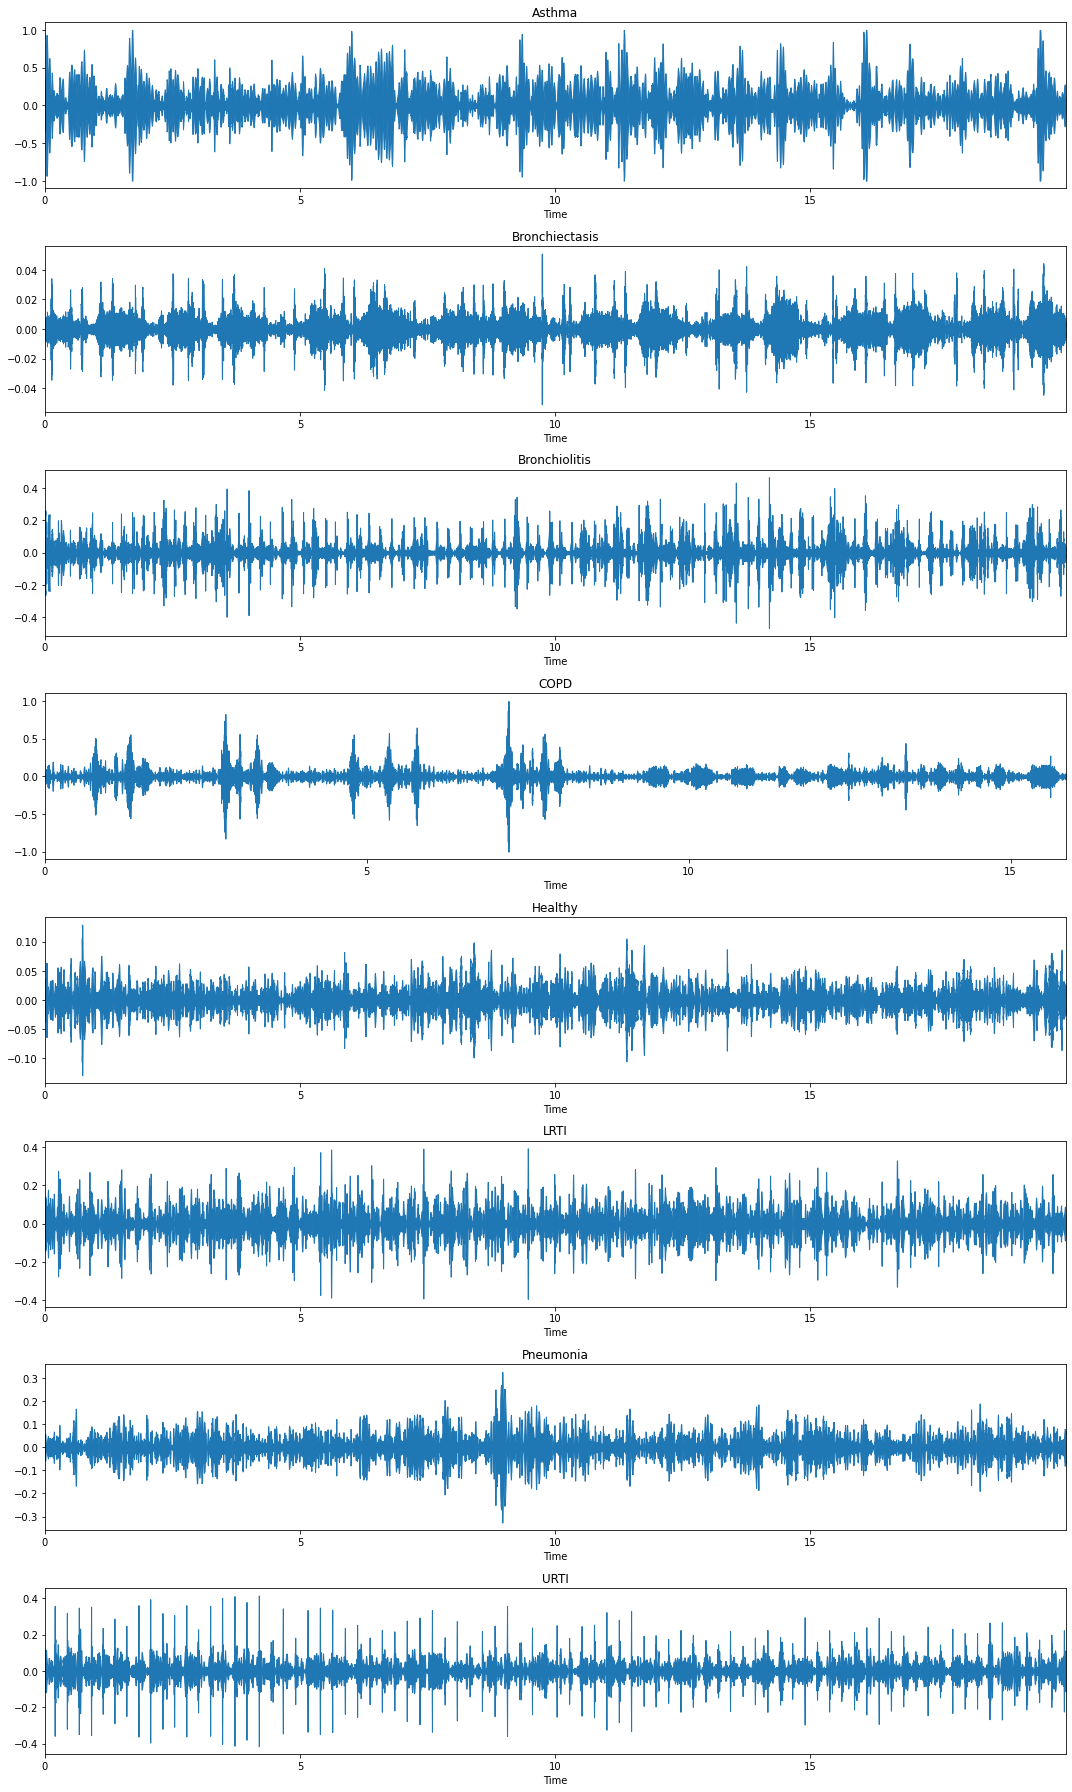

In [42]:
plt.figure(figsize=(15, 25))

plt.figure(1)

plt.subplot(811)
plt.title('Asthma')
ast, sr = lb.load('audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav', sr = 44100)
lb.display.waveplot(ast, sr=sr)

plt.subplot(812)
plt.title('Bronchiectasis')
bre, sr = lb.load('audio_and_txt_files/111_1b2_Tc_sc_Meditron.wav', sr = 44100)
lb.display.waveplot(bre, sr=sr)

plt.subplot(813)
plt.title('Bronchiolitis')
bro, sr = lb.load('audio_and_txt_files/149_1b1_Al_sc_Meditron.wav', sr = 44100)
lb.display.waveplot(bro, sr=sr)

plt.subplot(814)
plt.title('COPD')
bro, sr = lb.load('audio_and_txt_files/104_1b1_Al_sc_Litt3200.wav', sr = 44100)
lb.display.waveplot(bro, sr=sr)

plt.subplot(815)
plt.title('Healthy')
bro, sr = lb.load('audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav', sr = 44100)
lb.display.waveplot(bro, sr=sr)

plt.subplot(816)
plt.title('LRTI')
bro, sr = lb.load('audio_and_txt_files/108_1b1_Al_sc_Meditron.wav', sr = 44100)
lb.display.waveplot(bro, sr=sr)

plt.subplot(817)
plt.title('Pneumonia')
bro, sr = lb.load('audio_and_txt_files/122_2b1_Al_mc_LittC2SE.wav', sr = 44100)
lb.display.waveplot(bro, sr=sr)

plt.subplot(818)
plt.title('URTI')
bro, sr = lb.load('audio_and_txt_files/101_1b1_Al_sc_Meditron.wav', sr = 44100)
lb.display.waveplot(bro, sr=sr)

plt.tight_layout()

In [43]:
#Encode crackles and wheezes in single column
crack_wheez = []
for idx, row in file_data.iterrows():
    if row['crackles'] == 0 and row['wheezes'] == 0:
        crack_wheez.append(0)
    elif row['crackles'] == 1 and row['wheezes'] == 0:
        crack_wheez.append(1)
    elif row['crackles'] == 0 and row['wheezes'] == 1:
        crack_wheez.append(2)
    else:
        crack_wheez.append(3)

In [44]:
file_data['crack_wheez'] = crack_wheez 

In [45]:
file_data

,fname,pId,chloc,start,end,crackles,wheezes,diagnosis,Age,Sex,adult_BMI,child_weight,child_height,crack_wheez
0,101_1b1_Al_sc_Meditron,101,Al,0.036,0.579,0,0,URTI,3.0,F,0.0,19.0,99.0,0
1,101_1b1_Al_sc_Meditron,101,Al,0.579,2.450,0,0,URTI,3.0,F,0.0,19.0,99.0,0
2,101_1b1_Al_sc_Meditron,101,Al,2.450,3.893,0,0,URTI,3.0,F,0.0,19.0,99.0,0
3,101_1b1_Al_sc_Meditron,101,Al,3.893,5.793,0,0,URTI,3.0,F,0.0,19.0,99.0,0
4,101_1b1_Al_sc_Meditron,101,Al,5.793,7.521,0,0,URTI,3.0,F,0.0,19.0,99.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,226_1b1_Pl_sc_LittC2SE,226,Pl,11.721,13.693,1,0,Pneumonia,4.0,M,0.0,16.7,103.0,1
6894,226_1b1_Pl_sc_LittC2SE,226,Pl,13.693,15.536,0,0,Pneumonia,4.0,M,0.0,16.7,103.0,0
6895,226_1b1_Pl_sc_LittC2SE,226,Pl,15.536,17.493,0,0,Pneumonia,4.0,M,0.0,16.7,103.0,0
6896,226_1b1_Pl_sc_LittC2SE,226,Pl,17.493,19.436,1,0,Pneumonia,4.0,M,0.0,16.7,103.0,1


In [46]:
file_data.drop(columns=['crackles', 'wheezes'],inplace= True)

In [47]:
file_data

,fname,pId,chloc,start,end,diagnosis,Age,Sex,adult_BMI,child_weight,child_height,crack_wheez
0,101_1b1_Al_sc_Meditron,101,Al,0.036,0.579,URTI,3.0,F,0.0,19.0,99.0,0
1,101_1b1_Al_sc_Meditron,101,Al,0.579,2.450,URTI,3.0,F,0.0,19.0,99.0,0
2,101_1b1_Al_sc_Meditron,101,Al,2.450,3.893,URTI,3.0,F,0.0,19.0,99.0,0
3,101_1b1_Al_sc_Meditron,101,Al,3.893,5.793,URTI,3.0,F,0.0,19.0,99.0,0
4,101_1b1_Al_sc_Meditron,101,Al,5.793,7.521,URTI,3.0,F,0.0,19.0,99.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6893,226_1b1_Pl_sc_LittC2SE,226,Pl,11.721,13.693,Pneumonia,4.0,M,0.0,16.7,103.0,1
6894,226_1b1_Pl_sc_LittC2SE,226,Pl,13.693,15.536,Pneumonia,4.0,M,0.0,16.7,103.0,0
6895,226_1b1_Pl_sc_LittC2SE,226,Pl,15.536,17.493,Pneumonia,4.0,M,0.0,16.7,103.0,0
6896,226_1b1_Pl_sc_LittC2SE,226,Pl,17.493,19.436,Pneumonia,4.0,M,0.0,16.7,103.0,1


In [ ]:
def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
max_len_per_slice = max(file_data['end'].sub(file_data['start'], axis = 0))
max_len_per_slice

In [ ]:
box = plt.boxplot(file_data['end'].sub(file_data['start'], axis = 0))

In [ ]:
rel_max = [item.get_ydata()[1] for item in box['whiskers']][1]

In [ ]:
rel_max = np.ceil(rel_max) + 1

In [ ]:
#create output path
#os.makedirs('output')

In [ ]:
#for d in diag:
   #path = os.path.join('output', d)
    #os.makedirs(path)

In [ ]:
i = 0 #iterator for file naming

for idx, row in file_data.iterrows():
    filename = row['fname']
    start = row['start']
    end = row['end']
    diag = row['diagnosis']
    
    #check len and force to 6 sec if more than that
    if rel_max < end - start:
        end = start + rel_max
    
    aud_loc = 'audio_and_txt_files/' + f + '.wav'
    
    if idx != 0:
        if file_data.iloc[idx-1]['fname'] == filename:
            i=i+1
        else:
            i=0
    n_filename = filename + '_' + str(i) + '.wav'
    path = 'output/' + diag + '/' + n_filename
    
    data, samplingrate = lb.load(aud_loc, sr = 44100)
    sliced_data = slice_data(start=start, end=end, raw_data=data, sample_rate=samplingrate)
    
    #pad audio if < forced_max_len
    a_len = samplingrate * rel_max
    padded_data = lb.util.pad_center(sliced_data, a_len)

    sf.write(file=path, data=padded_data, samplerate=samplingrate)

In [ ]:
#os.makedirs('out')
#os.makedirs('out/train')
#os.makedirs('out/val')

In [ ]:
audio_loc = 'output/'

splitfolders.ratio(audio_loc, output='out', seed=100, ratio=(0.85, 0.15))

In [48]:
le = preprocessing.LabelEncoder()
file_data['diagnosis'] = le.fit_transform(file_data.diagnosis)

le.inverse_transform([0,1,2,3,4,5,6,7])

array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI'], dtype=object)

In [49]:
def audio_features(filename): 
    fn = 'output/' + filename 
    sound, sample_rate = lb.load(fn, sr = 44100) 
    stft = np.abs(librosa.stft(sound)) 
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
    mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
    return concat

In [ ]:
# Iterate through each sound file and extract the features 
features = []

for idx, row in file_data.iterrows():
    
    fn = row['fname']
    class_label = row["diagnosis"]
    if idx != 0:
        if file_data.iloc[idx-1]['fname'] == filename:
            i=i+1
        else:
            i=0
    n_filename = fn + '_' + str(i) + '.wav'
    
    data = audio_features(n_filename)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

In [ ]:
X = np.array(featuresdf.feature.tolist())

In [ ]:
Y = np.array(featuresdf.class_labels.tolist())

In [ ]:
#store X 
with h5py.File('features.hdf5', 'w') as f:
    dset = f.create_dataset("feat", data=X)

In [ ]:
#store Y
with h5py.File('labels.hdf5', 'w') as f:
    dset = f.create_dataset("class", data=Y)

In [52]:
#Load saved data
X = h5py.File('features.hdf5', 'r')

In [55]:
Xd = X['feat']

In [56]:
Xd.shape

(6898, 193)

In [57]:
#Load saved data
Y = h5py.File('labels.hdf5', 'r')

In [59]:
Yd = Y['class']

In [60]:
Yd.shape

(6898,)

In [61]:
Y = to_categorical(Yd)

In [63]:
Y.shape

(6898, 8)

In [64]:
X = np.reshape(Xd, (Xd.shape[0], Xd.shape[1], 1))

In [65]:
X.shape

(6898, 193, 1)

In [66]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [67]:
### store the preprocessed data for use in the next notebook

%store x_train 
%store x_test 
%store y_train 
%store y_test 

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)


In [72]:
#Depth seperable CNN

model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193,1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=300, verbose=1)

Train on 5518 samples, validate on 1380 samples
Epoch 1/50
5518/5518 [==============================] - 16s 3ms/sample - loss: 1.1141 - accuracy: 0.8043 - val_loss: 0.7830 - val_accuracy: 0.8413
Epoch 2/50
5518/5518 [==============================] - 14s 3ms/sample - loss: 0.7406 - accuracy: 0.8309 - val_loss: 0.7021 - val_accuracy: 0.8413
Epoch 3/50
5518/5518 [==============================] - 14s 3ms/sample - loss: 0.7193 - accuracy: 0.8309 - val_loss: 0.6770 - val_accuracy: 0.8413
Epoch 4/50
5518/5518 [==============================] - 15s 3ms/sample - loss: 0.6989 - accuracy: 0.8309 - val_loss: 0.6641 - val_accuracy: 0.8413
Epoch 5/50
5518/5518 [==============================] - 16s 3ms/sample - loss: 0.6863 - accuracy: 0.8309 - val_loss: 0.6430 - val_accuracy: 0.8413
Epoch 6/50
5518/5518 [==============================] - 15s 3ms/sample - loss: 0.6676 - accuracy: 0.8307 - val_loss: 0.6271 - val_accuracy: 0.8413
Epoch 7/50
5518/5518 [==============================] - 16s 3ms/sample

KeyboardInterrupt: 